$$
t = \alpha_1 F P_{+} t + \alpha_2 B P_{-} t + \alpha_3 d
$$

$$
\Phi(x) = x - \alpha_1 F P_{+} x + \alpha_2 B P_{-} x + \alpha_3 d, \\
\text{minimize} \quad \frac{1}{2} \|\Phi(x)\|^2_2 = F(x).
$$

Heaviside function:

$$
h(x) = \left\{ \begin{eqnarray}
1 \quad x > 0, \\
0 \quad x \le 0.
\end{eqnarray} \right.
$$

$$
\Phi_i = x_i - \alpha_1 \sum_{j = 1}^{N} F_{ij} h(x_j) x_j - \alpha_2 \sum_{j = 1}^{N} B_{ij} h(-x_j) x_j - \alpha_3 d, \\
\frac{\partial \Phi_i}{\partial x_q} = \delta_{iq} - \alpha_1 \sum_{j = 1}^{N} F_{ij} h(x_j) \delta_{jq} - \alpha_2 \sum_{j = 1}^{N} B_{ij} h(-x_j) \delta_{jq}, \\
\frac{\partial \Phi_i}{\partial x_q} = \delta_{iq} - \alpha_1 F_{iq} h(x_q) - \alpha_2 B_{iq} h(-x_q).
$$

$$
\frac{\partial F}{\partial x_q} = \sum_{i = 1}^{N} \Phi_i(x) \frac{\partial \Phi_i}{\partial x_q}, \\
\frac{\partial^2 F}{\partial x_p \partial x_q} = \sum_{i = 1}^{N} \left(\frac{\partial \Phi_i}{\partial x_p}\right) \left(\frac{\partial \Phi_i}{\partial x_q}\right) + \sum_{i = 1}^{N} \Phi_i(x) \frac{\partial^2 \Phi_i}{\partial x_p \partial x_q} \approx \sum_{i = 1}^{N} \left(\frac{\partial \Phi_i}{\partial x_p}\right) \left(\frac{\partial \Phi_i}{\partial x_q}\right).
$$

In [1]:
import numpy as np
import networkx as nx

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import time

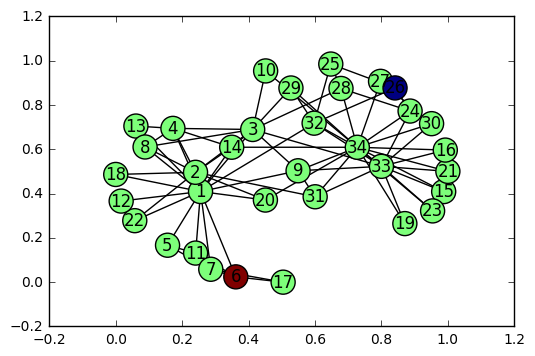

In [2]:
# karate network dataset

kn = nx.read_gml("karate.gml")
A = nx.adjacency_matrix(kn).todense()
nodes = [int(i) for i in kn.nodes()]
d = np.zeros(34)
d[nodes.index(6)] = 1
d[nodes.index(26)] = -1


nx.draw_networkx(kn, node_color=d)

In [3]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [4]:
a1 = 0.7
a2 = 0.7
a3 = 0.7

In [5]:
# we are looking for solution x == T(x)

def T(x):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [6]:
# RepRank

def RepRank(maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(x_prev)
        n = np.linalg.norm(x_next - x_prev)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

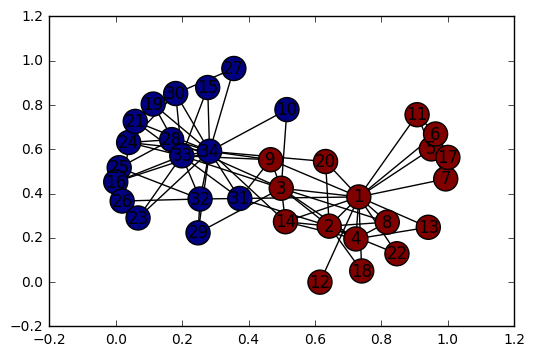

In [7]:
k, ans = RepRank()

ans[ans > 0] = 1
ans[ans < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [8]:
def h(x):
    ans = np.zeros_like(x)
    ans[x > 0.0] = 1.0
    return ans

In [9]:
def obj(x):
    return np.linalg.norm(x - T(x)) ** 2 / 2

In [10]:
def Jac(x):
    return np.eye(F.shape[0]) - a1 * np.multiply(F, h(x).reshape(-1, 1)) - a2 * np.multiply(B, h(-x).reshape(-1, 1))

In [11]:
def der(x):
    l = x - T(x)
    return Jac(x).T.dot(l)

In [12]:
def Hess(x):
    return Jac(x).T.dot(Jac(x))

In [13]:
def VanillaNewton(x0=None, maxiter=200, tol=1e-8):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        dx = np.linalg.solve(Hess(x_prev), -der(x_prev))
        x_next = x_prev + dx
        if obj(x_next) < tol:
            break
        x_prev = x_next.copy()
    return (k + 1, x_next.copy())

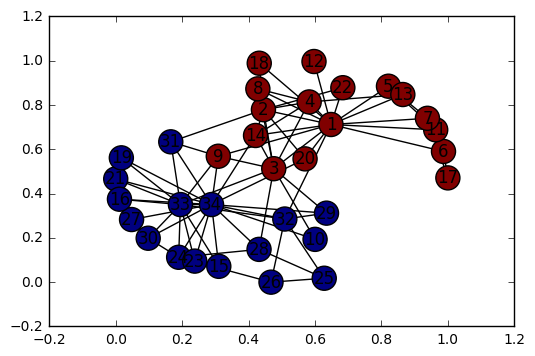

In [14]:
k, ans = VanillaNewton()

ans[ans > 0] = 1
ans[ans < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [17]:
RR_mean = np.empty(50)
RR_var = np.empty(50)
j = 0

for i in np.logspace(0, -11):

    tt = np.empty(1000)

    for i in range(len(tt)):
        begin = time.time()
        k, ans = RepRank(tol=i)
        end = time.time()
        tt[i] = end - begin
    RR_mean[j] = np.mean(tt)
    RR_var[j] = np.std(tt, ddof=1)
    j += 1

In [22]:
# performance of RepRank

tt = np.empty(1000)

for i in range(len(tt)):
    begin = time.time()
    k, ans = RepRank()
    end = time.time()
    tt[i] = end - begin
    
print("Average time spent: {}\nVariance : {}".format(str(np.mean(tt)), str(np.std(tt, ddof=1))))

Average time spent: 0.00125527186394
Variance : 0.000440150564163


In [23]:
# performance of Newton

tt = np.empty(5000)

for i in range(len(tt)):
    begin = time.time()
    k, ans = VanillaNewton()
    end = time.time()
    tt[i] = end - begin
    
print("Average time spent: {}\nVariance : {}".format(str(np.mean(tt)), str(np.std(tt, ddof=1))))

Average time spent: 0.00177670168877
Variance : 0.000516503508374


In [18]:
N_mean = np.empty(50)
N_var = np.empty(50)
j = 0

for i in np.logspace(0, -11):

    tt = np.empty(1000)

    for i in range(len(tt)):
        begin = time.time()
        k, ans = VanillaNewton(tol=i)
        end = time.time()
        tt[i] = end - begin
    N_mean[j] = np.mean(tt)
    N_var[j] = np.std(tt, ddof=1)
    j += 1

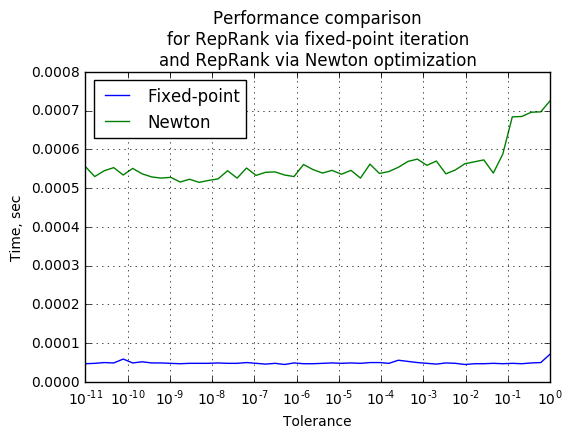

In [32]:
#plt.errorbar(np.logspace(0, -11), RR_mean, yerr=RR_var)
plt.plot(np.logspace(0, -11), RR_mean, label="Fixed-point")
#plt.errorbar(np.logspace(0, -11), N_mean, yerr=N_var)
plt.plot(np.logspace(0, -11), N_mean, label="Newton")

plt.xscale("log")
plt.xlabel("Tolerance")
plt.ylabel("Time, sec")
plt.title("Performance comparison\nfor RepRank via fixed-point iteration\nand RepRank via Newton optimization")
plt.grid()
plt.legend(loc="best")
plt.show()

In [12]:
def LineSearch(x, dx):
    alpha = obj(x) / np.linalg.norm(dx) ** 2
    while True:
        if obj(x + alpha * dx) < obj(x):
            return x + alpha * dx
        else:
            alpha /= 2

In [37]:


print(k)

74


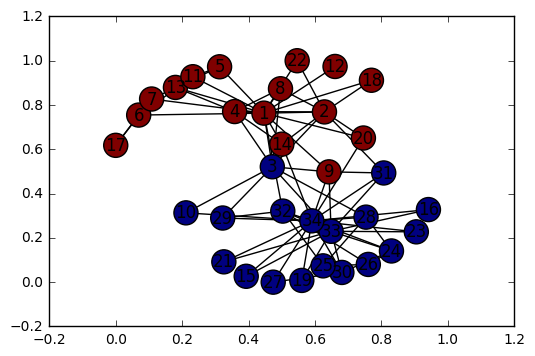

In [38]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [39]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = np.linalg.solve(Hess(x_prev), -der(x_prev))
    x_next = x_prev + dx
    if obj(x_next) < 1e-8:
        break
    print(k, obj(x_next))
    x_prev = x_next.copy()

0 0.0284364502781
1 0.00416541912519


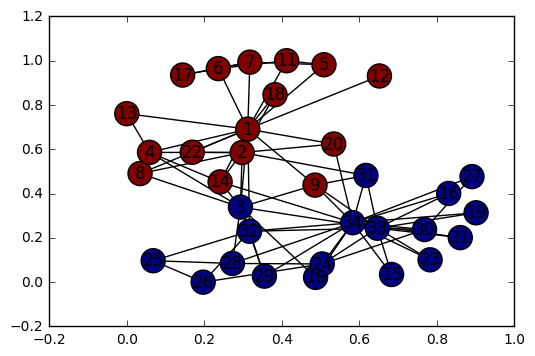

In [40]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)